# 0. 버전확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [2]:
# !pip install wandb

In [3]:
# !pip install torch

In [4]:
# !pip install wandb transformers scikit-learn

In [5]:
# !pip install transformers

In [6]:
# !pip install transformers sklearn

# Step 1. 데이터 수집하기
### new_train.csv사용

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

import transformers
from transformers import BertTokenizer, BertModel,  DistilBertForSequenceClassification, AdamW
from transformers import pipeline

from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


In [8]:
train_data_path ='/aiffel/aiffel/workplace/new_train.csv'
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [33]:
data = train_data.copy()

In [34]:
test_data_path ='/aiffel/aiffel/workplace/test.csv'
test_data = pd.read_csv(test_data_path)
test_data.head()

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [35]:
test = test_data.copy()

# Step 2. 데이터 전처리하기
### 5) 데이터 증강 외 모두 적용

#### **1) 한글 불용어 처리  2) 구두점 처리  3) 중복 공백 제거  4) 양쪽 공백 제거   6) 임베딩 방식(모델에서 처리해줌)**

In [36]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 12092


In [37]:
# 중복 확인
from collections import Counter

data_counts = Counter(data)
duplicates = {item: count for item, count in data_counts.items() if count > 1}

print("중복된 데이터:", duplicates)  # {1: 2} (1이 2번 등장)

중복된 데이터: {}


In [38]:
# 'class' 열과 'idx' 열에 누락값 확인
missing_class = data['class'].isnull().any()
missing_idx = data['idx'].isnull().any()

print("class 열에 누락값이 있습니까?", missing_class)  # True (누락값 있음)
print("idx 열에 누락값이 있습니까?", missing_idx)      # True (누락값 있음)


class 열에 누락값이 있습니까? False
idx 열에 누락값이 있습니까? False


In [39]:
import re

# 한글 불용어 목록
stopwords = [
    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"
]

def preprocess_korean_text(data):
    processed_texts = []

    for sentence in data:
        # 구두점 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

        # 중복 공백 제거
        sentence = re.sub(r'\s+', ' ', sentence)

        # 양쪽 공백 제거
        sentence = sentence.strip()

        processed_texts.append(sentence)

    return processed_texts

def remove_stopwords(data, stopwords):
    filtered_texts = []

    for sentence in data:
        # 텍스트를 공백으로 분리하여 단어 리스트 생성
        words = sentence.split()

        # 불용어가 아닌 단어만 필터링
        filtered_words = [word for word in words if word not in stopwords]

        # 필터링된 단어를 다시 문자열로 결합
        filtered_texts.append(' '.join(filtered_words))

    return filtered_texts


# conversation 열에 대해서만 전처리 및 불용어 제거 적용
data['conversation_processed'] = preprocess_korean_text(data['conversation'])
data['conversation_filtered'] = remove_stopwords(data['conversation_processed'], stopwords)

# 결과 확인
print(data[['conversation', 'conversation_processed', 'conversation_filtered']].head())


                                        conversation  \
0  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...   
1  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...   
2  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...   
3  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...   
4  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...   

                              conversation_processed  \
0  지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...   
1  길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...   
2  너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...   
3  어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...   
4  저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...   

                               conversation_filtered  
0  지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...  
1  길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...  
2  너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...  
3  어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...  
4  저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발..

In [40]:
data

,idx,class,conversation,conversation_processed,conversation_filtered
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...,...,...
12087,12087,일반,미안하다... 나 내일 회사 하루 쉬려고. 회사를? 어...너무 힘들어서 하루 쉬고...,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 이 오밤중에? 난 정말 나간다. 애들처럼 왜 이러냐고? 동네 창피...,아~엄마 뭐하는데 이 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네...,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가, 자 임마. 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가. 겁...","니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ...","니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어, 왜 일어나있어? 힘든데 누워있지. 아니, 이젠 괜찮아 오빠. 뭐가 괜찮아? 어...","어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜...","어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [41]:
# Q열과 A열 삭제
data = data.drop(columns=['conversation', 'conversation_processed'])
data

,idx,class,conversation_filtered
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [42]:
# 열 이름 변경
data = data.rename(columns={'conversation_filtered': 'conversation'})
data


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [43]:
# 열 이름 변경
data = data.rename(columns={'class': 'class_label'})
data

,idx,class_label,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


대화의 최소 길이 : 8
대화의 최대 길이 : 305
대화의 평균 길이 : 55.55946080052927


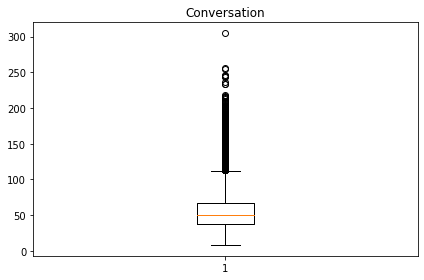

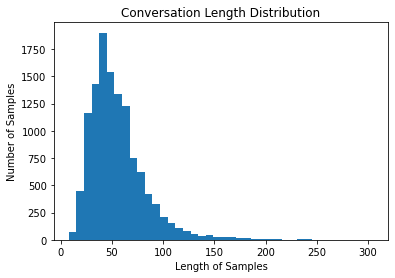

In [44]:
# 길이 분포 출력
conversation_len = [len(s.split()) for s in data['conversation']]
class_label_len = [len(s.split()) for s in data['class_label']]

print('대화의 최소 길이 : {}'.format(np.min(conversation_len)))
print('대화의 최대 길이 : {}'.format(np.max(conversation_len)))
print('대화의 평균 길이 : {}'.format(np.mean(conversation_len)))

# 길이 분포 시각화
plt.subplot(1, 1, 1)
plt.boxplot(conversation_len)
plt.title('Conversation')

plt.tight_layout()
plt.show()

plt.title('Conversation Length Distribution')
plt.hist(conversation_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()


In [45]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 120
print(MAX_LENGTH)

120


# (사용x)Step 3. SubwordTextEncoder 사용하기
#### BERT의 토크나이저는 이미 광범위한 텍스트 데이터로 **학습된 단어장을 포함하고 있으며, 문장을 정수로 인코딩하고 패딩하는 기능도 포함**되어 있습니다.  

KLUE-BERT와 같은 사전 학습된 BERT 모델을 사용하면,  
**단어장을 만들고 정수 인코딩 및 패딩을 처리하는 과정은 필요하지 않습니다.**



#### 1. 단어장(Vocabulary) 만들기

#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [46]:
# print(conversation[2])
# print(class_label[2])

In [47]:
'''
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': conversation,
        'dec_inputs': class_label[:, :-1]
    },
    {
        'outputs': class_label[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
'''

"\nBATCH_SIZE = 64\nBUFFER_SIZE = 20000\n\n# 디코더는 이전의 target을 다음의 input으로 사용합니다.\n# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.\ndataset = tf.data.Dataset.from_tensor_slices((\n    {\n        'inputs': conversation,\n        'dec_inputs': class_label[:, :-1]\n    },\n    {\n        'outputs': class_label[:, 1:]\n    },\n))\n\ndataset = dataset.cache()\ndataset = dataset.shuffle(BUFFER_SIZE)\ndataset = dataset.batch(BATCH_SIZE)\ndataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)\n"

In [48]:
import wandb
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [49]:
wandb.init(project="dim_reduction_example")


In [50]:
# WandB 프로젝트 초기화
wandb.init(project="dim_reduction_example")

# 예시 데이터: conversation에 정수 인코딩된 데이터가 있다고 가정
# conversation = np.random.randn(100, 300)  # 임의 데이터 예시
'''
# PCA 적용
pca = PCA(n_components=2)
pca_components = pca.fit_transform(conversation)

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(conversation)

# 시각화 결과를 WandB에 기록
wandb.log({
    "PCA Scatter Plot": wandb.plot.scatter(
        wandb.Table(data=[[x, y] for x, y in zip(pca_components[:, 0], pca_components[:, 1])],
                    columns=["PC1", "PC2"]),
        "PC1", "PC2", title="PCA of Data"
    ),
    "t-SNE Scatter Plot": wandb.plot.scatter(
        wandb.Table(data=[[x, y] for x, y in zip(tsne_components[:, 0], tsne_components[:, 1])],
                    columns=["Dim1", "Dim2"]),
        "Dim1", "Dim2", title="t-SNE of Data"
    )
})
'''

'\n# PCA 적용\npca = PCA(n_components=2)\npca_components = pca.fit_transform(conversation)\n\n# t-SNE 적용\ntsne = TSNE(n_components=2, random_state=42)\ntsne_components = tsne.fit_transform(conversation)\n\n# 시각화 결과를 WandB에 기록\nwandb.log({\n    "PCA Scatter Plot": wandb.plot.scatter(\n        wandb.Table(data=[[x, y] for x, y in zip(pca_components[:, 0], pca_components[:, 1])],\n                    columns=["PC1", "PC2"]),\n        "PC1", "PC2", title="PCA of Data"\n    ),\n    "t-SNE Scatter Plot": wandb.plot.scatter(\n        wandb.Table(data=[[x, y] for x, y in zip(tsne_components[:, 0], tsne_components[:, 1])],\n                    columns=["Dim1", "Dim2"]),\n        "Dim1", "Dim2", title="t-SNE of Data"\n    )\n})\n'

# step 4. 모델 정의

#### 9-4. KLUE-BERT 가져오기

## KLUE-BERT와 t-SNE를 사용한 시각화

주요 단계 요약:
1. KLUE-BERT 모델과 토크나이저 로드  
2. 텍스트 데이터를 KLUE-BERT 임베딩으로 변환  
3. t-SNE를 사용하여 차원 축소  
4. t-SNE 시각화  

> t-SNE, 	**작은 데이터셋**의 클러스터링된 패턴을 탐색하거나, 데이터의 **국소적 특성**을 시각화하기 좋음.


**작은 데이터셋인가?**
-> 크기 측면에서 보면, 데이터셋의 크기가 12,092개의 샘플로 되어 있는 중간 크기의 데이터셋  
=> (t-SNE를 사용하는 데 무리가 없는 크기, 매우 크지는 않아서 빠르게 처리가능)



**국소적 특성**
-> 협박과 관련된 문장들이 같은 공간에 모이고, 갈취와 직장 내 괴롭힘은 다른 영역에 모이는지 등 우리의 상식과 비슷한지 확인하고자 함.  
-> 세부적으로 어떤 문장들이 더 유사한지를 탐구

### 1.KLUE-BERT 모델과 토크나이저 로드

In [51]:
# KLUE-BERT 모델과 토크나이저 로드
# tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
# model = BertModel.from_pretrained("klue/bert-base") # BertForSequenceClassification 대신 BertModel 사용

# model = BertForSequenceClassification.from_pretrained("klue/bert-base")
# ERROR : AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

**1. 다시 시도 :  모델과 토크나이저 로드 (경량화된 모델사용)**

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
# DistilBERT 모델과 토크나이저 로드 (경량화된 모델 사용)
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(train_data['class'].unique()))
model.to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

### 2. 텍스트 데이터를 KLUE-BERT 임베딩으로 변환  

시간 진짜 오래 걸림;;;;
image.png
image.png
image.png
image.png

In [54]:
'''# 텍스트를 BERT 임베딩으로 변환하는 함수
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():  # 모델 학습을 하지 않으므로 gradient 계산을 하지 않음
        outputs = model(**inputs)
    # CLS 토큰의 임베딩만 사용 (배치에서 첫 번째 토큰)
    return outputs.last_hidden_state[:, 0, :].numpy()

# 데이터에서 텍스트 열을 사용하여 BERT 임베딩 계산
embeddings = np.array([get_bert_embeddings(text) for text in data['conversation']])'''


"# 텍스트를 BERT 임베딩으로 변환하는 함수\ndef get_bert_embeddings(text):\n    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)\n    with torch.no_grad():  # 모델 학습을 하지 않으므로 gradient 계산을 하지 않음\n        outputs = model(**inputs)\n    # CLS 토큰의 임베딩만 사용 (배치에서 첫 번째 토큰)\n    return outputs.last_hidden_state[:, 0, :].numpy()\n\n# 데이터에서 텍스트 열을 사용하여 BERT 임베딩 계산\nembeddings = np.array([get_bert_embeddings(text) for text in data['conversation']])"

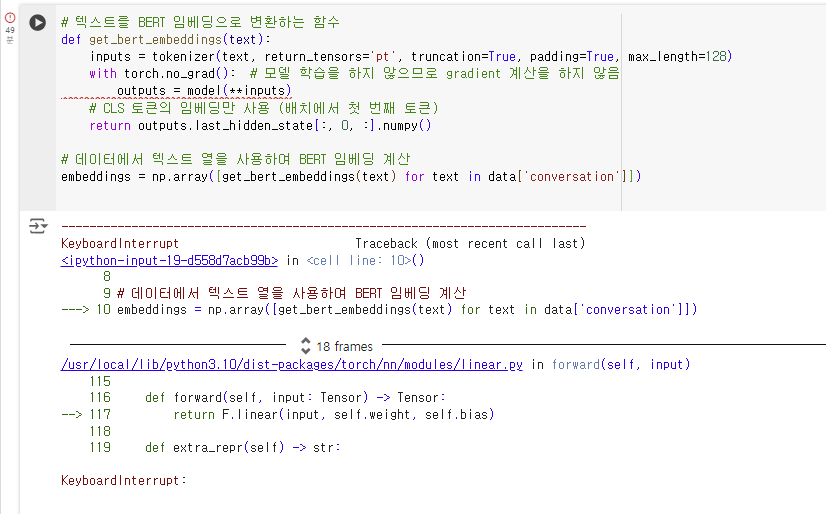

### **다시 시도 : 토크나이징과 데이터 로드**

In [55]:
# 데이터셋 클래스 정의 (토크나이징과 데이터 로드)
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

### 훈련 및 테스트 데이터 준비

In [63]:
print( data['class_label'][2],"\n")
print( data['conversation'][2],"\n")

print( test['idx'][2],"\n")
print( test['text'][2])

기타 괴롭힘 대화 

너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 재미없어 . 지영아 너가 키 160이지 ? 그럼 재는 160도 안돼는거네 ? 너 군대도 안가고 좋겠다 . 니들이 나 작은데 보태준거 있냐 ? 난쟁이들도 장가가고하던데 . 너도 희망을 가져봐 더이상 하지마라 . 키크는 수술도 있대잖아 ? 니네 엄마는 그거 안해주디 ? 나람 해줬어 . 키로 어찌살아 . 제발 그만 괴롭히라고 ! 

t_002 

너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요


In [57]:
# 훈련 및 테스트 데이터 준비 (배치 크기 줄임)
train_texts = data['conversation'].tolist()  # 전처리된 텍스트 사용
train_labels = data['class_label'].tolist()

test_texts = test['text'].tolist()  # 전처리된 텍스트 사용
test_labels = test['idx'].tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # 배치 크기 줄임
test_loader = DataLoader(test_dataset, batch_size=8)

### 학습 & 평가 설정

In [58]:
# 6. Mixed Precision 설정
scaler = GradScaler()

# 7. 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# Gradient Accumulation 설정 (큰 배치 크기를 시뮬레이션)
accumulation_steps = 4

In [59]:
# 8. 학습 함수 정의 (Mixed Precision 적용 및 Gradient Accumulation)
def train_epoch(model, data_loader, optimizer, device, accumulation_steps, scaler):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    optimizer.zero_grad()

    for idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():  # Mixed Precision
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        scaler.scale(loss).backward()

        if (idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total += len(labels)
        losses.append(loss.item())

    return correct_predictions.double() / total, np.mean(losses)

# 9. 평가 함수 정의
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

### F1 Score 계산

In [60]:
# 10. 학습 및 성능 평가
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, accumulation_steps, scaler)
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

# 테스트 데이터에서 성능 평가
predictions, true_labels = evaluate(model, test_loader, device)

# F1 Score 계산
f1 = f1_score(true_labels, predictions, average='weighted')
print(f'F1 Score: {f1}')

Epoch 1/3


TypeError: new(): invalid data type 'str'

## wandb시각화 :  t-SNE

In [ ]:
# t-SNE로 3차원 축소
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(embeddings.squeeze())

# t-SNE 결과를 WandB로 로그
wandb.log({
    "3D t-SNE Visualization": wandb.plot.scatter(
        wandb.Table(data=[[x, y, z, label] for x, y, z, label in zip(
            tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], data['class']
        )],
        columns=["TSNE-1", "TSNE-2", "TSNE-3", "class"]),
        "TSNE-1", "TSNE-2", "TSNE-3", title="3D t-SNE Visualization of KLUE-BERT Embeddings")
})

# wandb.finish()로 세션 종료
wandb.finish()

In [ ]:
# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings.squeeze())

# t-SNE 결과를 데이터프레임에 추가
data['tsne_1'] = tsne_results[:, 0]
data['tsne_2'] = tsne_results[:, 1]

# t-SNE 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="class",  # 'class' 열을 사용하여 카테고리별로 색상 구분
    palette=sns.color_palette("hsv", as_cmap=True),
    data=data,
    legend="full"
)
plt.title('t-SNE Visualization of KLUE-BERT Embeddings')
plt.show()

## 파이프라인을 이용한 테스트

In [ ]:
# KLUE-BERT 토크나이저로 토큰화 및 인코딩
inputs = tokenizer(
    processed_texts.tolist(),  # 전처리된 텍스트 리스트
    return_tensors="pt",       # PyTorch 텐서로 반환
    padding=True,              # 패딩 적용
    truncation=True,           # 최대 길이 초과시 잘라내기
    max_length=128             # 최대 길이 설정 (128 토큰)
)

In [ ]:
# KLUE-BERT 모델에 입력하여 임베딩 또는 예측값 얻기
with torch.no_grad():  # 학습이 아닌 예측을 수행하므로 gradient 계산하지 않음
    outputs = model(**inputs)

# 모델 출력 확인
# CLS 토큰에 해당하는 임베딩 벡터 추출
cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 임베딩


In [ ]:
# 파이프라인을 이용한 테스트
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 예시 문장 테스트
text = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."
result = nlp(text)

print(result)

In [ ]:
# 예시 문장 테스트
text = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."
result = nlp(text)

print(result)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("klue/bert-base")
print(model.config.id2label)


In [ ]:
output = predict('아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네')

In [ ]:
output = predict('우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.')

In [ ]:
output = predict('너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요')

#### 위에건 일반 대화 아닌가? 애매함ㅎ. 2 epochs에서는 일반 대화로 분류함

In [ ]:
output = predict('국희씨 네? 이번주말에 뭐해? 애들이랑 키즈카페 가기러했어요 어 사실 나도 아까 점심먹을때 들어서 알고 있었는데 확인차 물어봤어 왜그러세요? 응 우리애들이랑 국희씨 애들이랑 나이도 얼추 비슷한데 주말에 키즈카페 좀 데려가주라 네?? 실장님은 안가시구요? 어 나는 집도 좀 치우고 밀린 일좀 보게 부탁할게 하지만 제가 애들 4명이나 보기엔 우리애들 얌전하니까 너무걱정마 내가 주의줄게 그럼 주말에 우리집앞으로 와')

In [ ]:
output = predict('저기요 제가 파워블로거에 맘카페까지 활동하고 있어요.  아.네. 멋지시네요!!!! 파워블로거 분들이 쓰신글을 조금 믿음이 가더라구요. 그쵸? 와 된장찌개 진짜 잘 먹었어요. 요리 솜씨가 좋네요 이만 가보겠습니다. 저기요 손님 밥 값 지불 안 하셨는데요! 네? 저 파워블로거라니까요? 제가 홍보해드릴건데 밥은 무료로 주셔야죠 저 홍보해달라고 한 적 없는데요 와서 빨리 밥값내고 가세요. 저 홍보해달라고 한 적 없어요. 그렇게 말 번복하시면 안되죠. 엄연한 계약 사항인데. 제가 언제리뷰해달라고 했어요 그냥 멋지시다고 했죠 빨리 돈내고 가세요. 나참 어이가 없네 아주 안 좋게 적을거니까 각오하세요. 하. 그냥 돈 내지말고 가세요. 그냥 가셔도 됩니다.')